In [1]:
"""
Note: I didn't want to include the model weights to github bc of its size, 
so you might need to download them yourself

path in savio:
/global/scratch/tlu2000/dev/models/

it was saved to ../models/ when I ran it
""";

# Observations:
# start/end tokens dont seem to make a big change - category of the constituent? (np, sentence frag, etc)
# structure mostly preserved when not splitting constituents / necessary info

In [2]:
import sys
sys.path.append("../src")
import torch
from benepar2 import decode_chart
from benepar2 import nkutil
from benepar2 import parse_chart
from tree_transforms import collapse_unlabel_binarize
from treebanks import ParsingExample, Treebank
import numpy as np
from nltk.tree import Tree
import matplotlib.pyplot as plt

In [3]:
class IParser():
    def __init__(self, model_path_base):
#         self.info = torch.load(model_path_base, map_location=lambda storage, location: storage)
        self.parser = parse_chart.ChartParser.from_trained(model_path_base)
    
    def remove_pos(self, tree):
        """
        mutates tree to remove the POS that has to be added
        """
        if isinstance(tree, str) or len(tree) < 1:
            return
        for i in range(len(tree)):
            if isinstance(tree[i], str):
                continue
            elif tree[i].label() == 'UNK':
                tree[i] = tree[i][0]
            else:
                self.remove_pos(tree[i])
    
    def parse_sentence(self, words):
        if isinstance(words, str): 
            words = words.split()
        if words[-1] == '.':
            words.pop(-1)
        treebank = Treebank([
            ParsingExample(tree=None, words=words, space_after=[True for w in words],\
                           _pos=[(w, 'UNK') for w in words])
        ])
        tree, cats = self.parser.parse(treebank, return_cats=True, tau=0)[0]
        self.remove_pos(tree)
        for i in range(len(tree.leaves())):
            tree[tree.leaf_treeposition(i)] = tree[tree.leaf_treeposition(i)] + "\n {}".format(cats[i+1])
        return tree, cats
    
    def tree_from_cats(self, cats, words='cat'):
        tree = self.parser.parse([cats], tau=0)[0]
        self.remove_pos(tree)
        return tree

In [4]:
iparse = IParser("../models/gpn_tau_d16_b16_ar2e-5_layers12_heads12_7526289_dev=94.69.pt")

gpt2


Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ 5  0  9 13  8 11  7  5 11 10 13  1  8  2 13  2  8 15  7  8  5  8  5  5
 10 11  2  1  9 13 11  8  5]


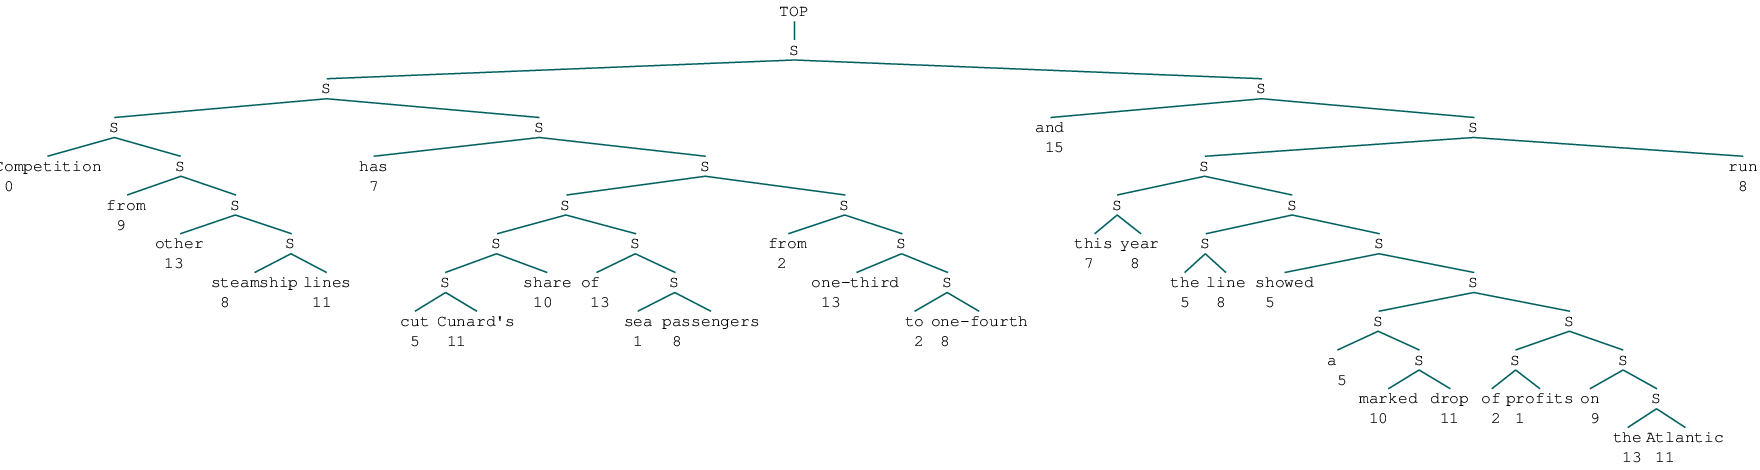

In [53]:
tree2, cats = iparse.parse_sentence("Competition from other steamship lines has cut Cunard's share of sea passengers from one-third to one-fourth and this year the line showed a marked drop of profits on the Atlantic run")
print(cats)
display(tree2)

[ 2  0  9 13  8 11  7  5 11 10 13  1  8  2 13  2  8  2]


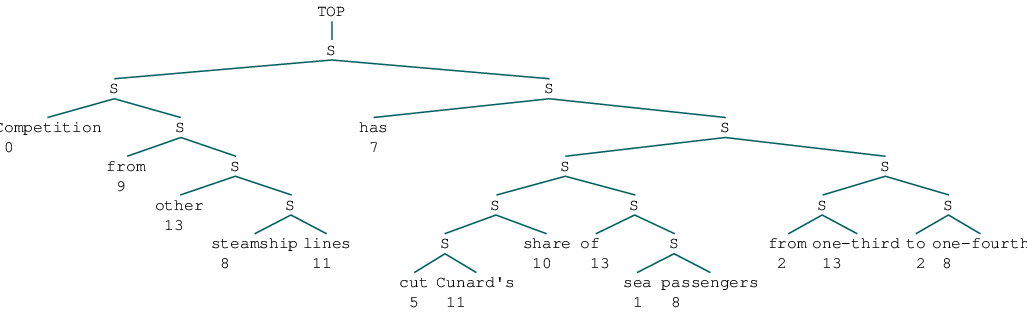

In [56]:
tree2, cats = iparse.parse_sentence("Competition from other steamship lines has cut Cunard's share of sea passengers from one-third to one-fourth")
print(cats)
display(tree2)

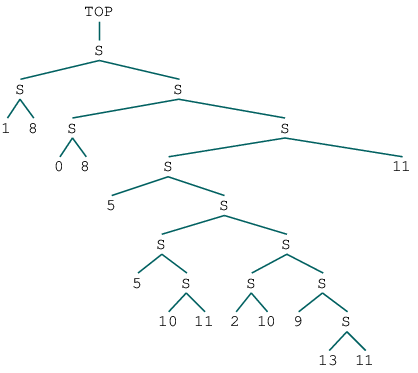

In [25]:
iparse.tree_from_cats([ 15,  1,  8,  0,  8,  5,  5, 10, 11,  2, 10,  9, 13, 11, 11,  15])

In [ ]:
# # 13, 11, 8, 5
# 13 right branch
# 11 chains create groups (right branches by convention)
#     makes next category branch up
# 7 & 13 creates aunt of group of  11s, paired with first 11
# 7 creates aunt of group of  13s, paired with first 13
# 15 starts a new branch

iparse.tree_from_cats([15,11, 11, 11, 11, 13, 11, 11, 13, 11, 15])

['Masaryk', 'award'] 2
4


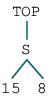

[ 2 15  8  2]

['(', 'He', 'played', 'host', 'at', 'the', 'Timex', 'show', 'already', 'mentioned', '.'] 11
12


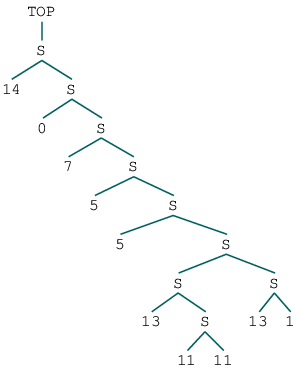

[ 2 14  0  7  5  5 13 11 11 13  1  2]

['Competition', 'from', 'other', 'steamship', 'lines', 'has', 'cut', "Cunard's", 'share', 'of', 'sea', 'passengers', 'from', 'one-third', 'to', 'one-fourth', 'and', 'this', 'year', 'the', 'line', 'showed', 'a', 'marked', 'drop', 'of', 'profits', 'on', 'the', 'Atlantic', 'run', '.'] 32
33


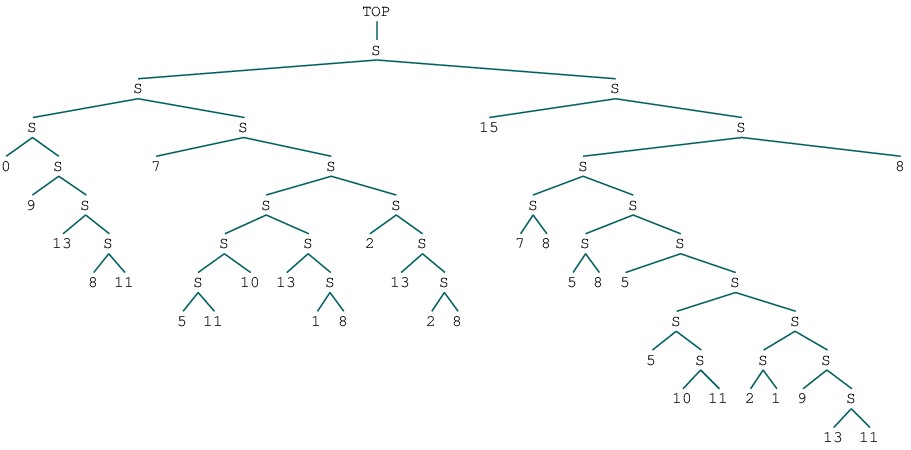

[ 5  0  9 13  8 11  7  5 11 10 13  1  8  2 13  2  8 15  7  8  5  8  5  5
 10 11  2  1  9 13 11  8  5]

['When', 'a', 'dancer', 'does', 'well', ',', 'she', 'provokes', 'a', 'quiet', 'bombardment', 'of', 'dollar', 'bills', '--', 'although', 'the', 'Manhattan', 'clubs', 'prohibit', 'the', 'more', 'cosmopolitan', 'practice', 'of', 'slipping', 'the', 'tips', 'into', 'the', "dancers'", 'costumes', '.'] 33
34


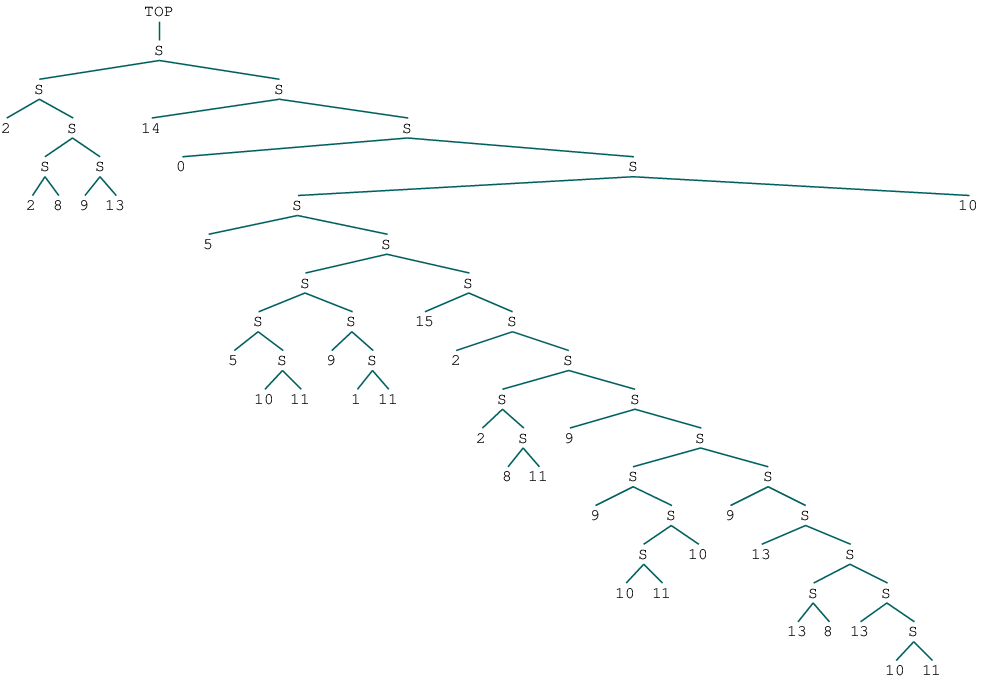

[ 2  2  2  8  9 13 14  0  5  5 10 11  9  1 11 15  2  2  8 11  9  9 10 11
 10  9 13 13  8 13 10 11 10  2]



In [13]:
from nltk.corpus import brown
brown_sents = brown.sents(categories=['editorial', 'reviews'])
size_brown = len(brown_sents)

for i in np.random.randint(size_brown, size=4):
    sent = brown_sents[i]
    print(sent, len(sent))
    tree, categories = iparse.parse_sentence(sent)
    print(len(categories))
    for i, leafPos in enumerate(tree.treepositions('leaves')):
        tree[leafPos] = categories[i+1]
    display(tree)
    print(categories, end='\n\n')

In [ ]:


def tree_diff_node(tree1, tree2, num_prev=2):
    """
    returns the part of the tree where a change occured. 
    """
    diff = [tree1, tree2]
    while True:
        tree1, tree2 = diff
        if tree1 == tree2:
            return "no change"
        if len(tree1) != len(tree2):
            return tree1, tree2
        diff = []
        for sub1, sub2 in zip(tree1, tree2):
            if sub1 != sub2:
                if not diff:
                    diff = [sub1, sub2]
                else:
                    return tree1, tree2

                
def sister(tree2):
    # use tree_diff_node, second tree follows /\
    tree2 = tree2[0]
    leaves = tree2.leaves()
    t2 = tree2[tree2.treeposition_spanning_leaves(len(leaves)-2, len(leaves))]
    display(t2)
    return len(t2) > 1 and t2[-1] == leaves[-1] and t2[-2] == leaves[-2]

def aunt(tree2):
    # new token c-commands old
    # use tree_diff_node, new token child of root, but not old
    tree2 = tree2[0]
    leaves = tree2.leaves()
    t2 = tree2[tree2.treeposition_spanning_leaves(len(leaves)-2, len(leaves))]
#     display(t2)
    return len(t2) > 1 and t2[-1] == leaves[-1] and t2[-2] != leaves[-2]



In [ ]:
tree1, categories1 = iparse.parse_sentence('I wanted cake')
display(tree1)
tree2, categories2 = iparse.parse_sentence('I wanted cake and')
display(tree2)
print('sis', sister(tree2))
print('aunt', aunt(tree2))

In [ ]:
tree1, categories1 = iparse.parse_sentence('I thought I ate ')
display(tree1)
tree2, categories2 = iparse.parse_sentence('I thought I ate him.')
display(tree2)
print('top', to_top(tree2))
print('sis', sister(tree2))
print('aunt', aunt(tree2))

In [ ]:
from collections import defaultdict

def make_stat_dict(cats):
    stat_dict = {'sis': defaultdict(int), 'aunt': defaultdict(int), 'n':defaultdict(lambda x: 1)}

    for cat in cats:
        if isinstance(cat[0], int):
            tree = iparse.tree_from_cats(cat, words='idx')
        else:
            try:
                tree, _ = iparse.parse_sentence(cat)
            except:
                continue
        last2 = tuple(cat[-3:-1])
        stat_dict['n'][last2] += 1
        for label, func in [['sis', sister], ['aunt', aunt]]:
            if func(tree):
                stat_dict[label][last2] += 1

    return stat_dict

def num2list(i, cats=4, sen_len=4):
    curr = []
    for _ in range(sen_len):
        curr.append(i % cats)
        i //= cats
    return curr

def print_proportions(cats, num_cats=4):
    stat_dict = make_stat_dict(cats)
    print("proportions of each class")
    for label, d in stat_dict.items():
        if label != 'n':
            if sum(stat_dict['n'].values()) > 0:
                print(label, sum(d.values()) / sum(stat_dict['n'].values()))
    print("_"*50, '\n')
    
    print("as last key")
    for i in range(num_cats):
        print('Key: ', i)
        for label, d in stat_dict.items():
            if label != 'n':
                a = 0
                n = 0
                for j in range(num_cats):
                    a += d[(j, i)]
                    n += stat_dict['n'][(j, i)]
                if n > 0:
                    print(label, a / n, '\n')
    print("_"*50, '\n')
    
    print("as second to last key")
    for i in range(num_cats):
        print('Key: ', i)
        for label, d in stat_dict.items():
            if label != 'n':
                a = 0
                n = 0
                for j in range(num_cats):
                    a += d[(i,j)]
                    n += stat_dict['n'][(i,j)]
                if n > 0:
                    print(label, a / n, '\n')
    print("_"*50, '\n')
    for key in stat_dict['n'].keys():
        print("Key: ", key)
        for label, d in stat_dict.items():
            if label != 'n':
                if sum(stat_dict['n'].values()) > 0:
                    print(label, d[key] / stat_dict['n'][key], '\n')
        print('='*50, '\n')

In [ ]:
def make_gen(num_words, num_cats=4):
    for i in range(num_cats**num_words):
        yield [1] + num2list(i, cats=num_cats, sen_len=num_words) + [0]
        
print('2 words')
print_proportions(make_gen(2, num_cats=4))

4748








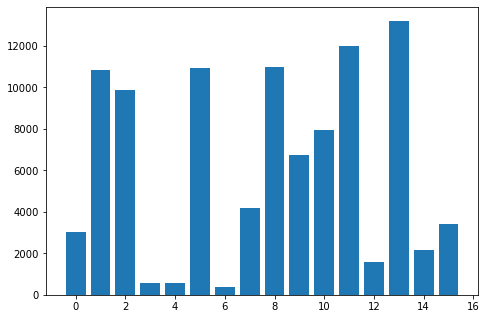

In [5]:
from nltk.corpus import brown
brown_sents = brown.sents(categories=['editorial', 'reviews'])

counts = np.zeros(16)
print(len(brown_sents))
for sent in brown_sents: 
    try:
        tree, cats = iparse.parse_sentence(sent)
        cats = cats[1:-1]
        for c in cats:
            counts[c] += 1
    except:
        print(' '.join(sent))


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = list(range(16))
ax.bar(langs,counts)
plt.show()
# 13, 11, 8, 5

In [6]:
import pandas as pd
ordered_categories = pd.DataFrame({'Tag':list(range(16)), 'Count': counts}).sort_values('Count', ascending=False)
ordered_categories

,Tag,Count
13,13,13206.0
11,11,11956.0
8,8,10961.0
5,5,10898.0
1,1,10831.0
2,2,9863.0
10,10,7952.0
9,9,6716.0
7,7,4190.0
15,15,3427.0


In [ ]:
from nltk.corpus import brown
brown_sents = brown.sents(categories=['editorial', 'reviews'])

batch_size = 500
batch = []
for sent in brown_sents: 
    try:
        tree, cats = iparse.parse_sentence(sent)
        batch.append(cats)
#         if len(batch) >= batch_size:
            
#             batch = []
    except:
        pass
print_proportions(batch, num_cats=16)